# Description

**TODO**

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import conf

# Settings

In [3]:
OUTPUT_DIR = conf.RESULTS["DRUG_DISEASE_ANALYSES"]
display(OUTPUT_DIR)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/media/miltondp/Elements1/projects/phenoplier/results/drug_disease_analyses')

# Load predictions

## Across all tissues

In [4]:
input_file = Path(OUTPUT_DIR, "predictions", "predictions_results.pkl").resolve()
display(input_file)

PosixPath('/media/miltondp/Elements1/projects/phenoplier/results/drug_disease_analyses/predictions/predictions_results.pkl')

In [5]:
predictions = pd.read_pickle(input_file)

In [6]:
predictions.shape

(64600, 6)

In [7]:
predictions.head()

,trait,drug,score,true_class,method,data
0,DOID:0050741,DB00215,251.0,1,Gene-based,spredixcan-mashr-zscores-Adipose_Subcutaneous-...
1,DOID:0050741,DB00704,307.0,1,Gene-based,spredixcan-mashr-zscores-Adipose_Subcutaneous-...
2,DOID:0050741,DB00822,94.0,1,Gene-based,spredixcan-mashr-zscores-Adipose_Subcutaneous-...
3,DOID:10283,DB00014,69.0,1,Gene-based,spredixcan-mashr-zscores-Adipose_Subcutaneous-...
4,DOID:10283,DB00175,254.0,0,Gene-based,spredixcan-mashr-zscores-Adipose_Subcutaneous-...


## Aggregated (across all tissues)

In [8]:
input_file = Path(
    OUTPUT_DIR, "predictions", "predictions_results_aggregated.pkl"
).resolve()
display(input_file)

PosixPath('/media/miltondp/Elements1/projects/phenoplier/results/drug_disease_analyses/predictions/predictions_results_aggregated.pkl')

In [9]:
predictions_avg = pd.read_pickle(input_file)

In [10]:
predictions_avg.shape

(1292, 5)

In [11]:
predictions_avg.head()

,trait,drug,method,score,true_class
0,DOID:0050741,DB00215,Gene-based,379.0,1.0
1,DOID:0050741,DB00215,Module-based,541.0,1.0
2,DOID:0050741,DB00704,Gene-based,483.0,1.0
3,DOID:0050741,DB00704,Module-based,562.0,1.0
4,DOID:0050741,DB00822,Gene-based,579.0,1.0


# ROC

In [12]:
methods_names = tuple(predictions["method"].unique())
assert len(methods_names) == 2
display(methods_names)

('Gene-based', 'Module-based')

In [13]:
methods_colors = {methods_names[0]: "red", methods_names[1]: "blue"}

## Functions

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve

In [15]:
def plot_roc(data, method_key, fig, ax, remove_non_informative=False):
    roc_auc = roc_auc_score(data["true_class"], data["score"])

    fpr, tpr, thresholds = roc_curve(data["true_class"], data["score"])
    #     print(f'  Points for ROC curve: {len(fpr)}')
    if remove_non_informative:
        cond = (fpr < 1.0) & (tpr < 1.0)
        fpr = fpr[cond]
        tpr = tpr[cond]
        print(f"  Points for ROC curve (after prunning): {len(fpr)}")

    label = f"{method_key} - AUC: {roc_auc:.3f}"
    sns.lineplot(
        x=fpr,
        y=tpr,
        estimator=None,
        label=label,
        ax=ax,
        linewidth=1.00,
        linestyle="-",
        color=methods_colors[method_key],
    )

In [16]:
def plot_roc_for_methods(selected_methods):
    with sns.plotting_context("paper", font_scale=3.00):
        fig, ax = plt.subplots(figsize=(10, 10))

        for method_name in selected_methods:
            data = predictions_avg[predictions_avg["method"] == method_name]
            plot_roc(data, method_name, fig, ax)

        #         ax.set_title('ROC curves using PharmacotherapyDB')
        ax.plot([0.0, 1.00], [0.0, 1.00], color="gray", linewidth=1.25, linestyle="-")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_xlim([0.0, 1.01])
        ax.set_ylim([0.0, 1.01])
        #                 ax.legend(loc="lower right")
        ax.set_aspect("equal")


#         ax.get_legend().remove()

## Plots

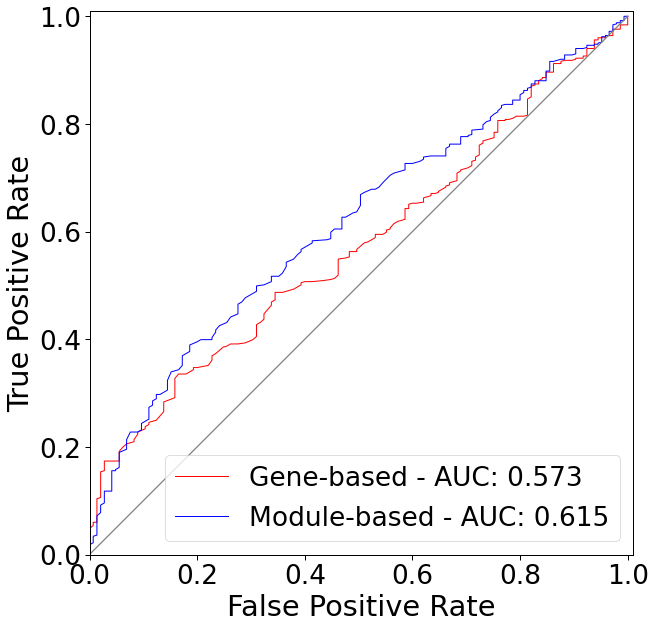

In [17]:
plot_roc_for_methods(methods_names)
# plt.savefig('/tmp/roc.pdf', bbox_inches='tight')

# Precision-Recall

## Functions

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [19]:
def plot_pr_raw_data(recall, precision, label, **kwargs):
    sns.lineplot(x=recall, y=precision, label=label, **kwargs)


def plot_pr(data, method_key, fig, ax, estimator=None, remove_non_informative=False):
    precision, recall, thresholds = precision_recall_curve(
        data["true_class"], data["score"]
    )
    if remove_non_informative:
        cond = recall < 1.0
        recall = recall[cond]
        precision = precision[cond]

    ap = average_precision_score(data["true_class"], data["score"])

    label = f"{method_key} - AP: {ap:.3f}"
    plot_pr_raw_data(
        recall,
        precision,
        label,
        estimator=estimator,
        ax=ax,
        linewidth=1.00,
        linestyle="-",
        color=methods_colors[method_key],
    )

In [20]:
def get_random_classifier_pr(data, reps=10, min_val=0, max_val=1):
    random_precision = []
    random_recall = []
    random_average_precision = []

    for i in range(reps):
        random_score = np.random.permutation(data["score"].values)
        rp, rr, _ = precision_recall_curve(data["true_class"], random_score)
        random_precision.extend(rp)
        random_recall.extend(rr)
        random_average_precision.append(
            average_precision_score(data["true_class"], random_score)
        )

    return (
        np.array(random_recall),
        np.array(random_precision),
        np.array(random_average_precision),
    )

In [21]:
def plot_pr_for_methods(selected_methods):
    with sns.plotting_context("paper", font_scale=3.00):
        fig, ax = plt.subplots(figsize=(10, 10))

        for method_name in selected_methods:
            data = predictions_avg[predictions_avg["method"] == method_name]
            plot_pr(data, method_name, fig, ax)

        # add random classifier
        #     random_recall, random_precision = get_random_classifier_pr(predictions['multixcan_mashr'].shape[0], predictions['multixcan_mashr'])
        random_recall, random_precision, random_averages = get_random_classifier_pr(
            data, reps=100
        )
        #         display(len(random_recall))
        random_label = f"Random - AP: {random_averages.mean():.3f}"
        plot_pr_raw_data(
            random_recall,
            random_precision,
            random_label,
            estimator="mean",
            ax=ax,
            ci="sd",
            color="gray",
        )

        #         ax.set_title('Precision-Recall curves using PharmacotherapyDB')
        # ax.plot([0.00, 1.00], [1.00, 0.00], color='gray', linewidth=0.50)
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_xlim([0.0, 1.01])
        ax.set_ylim([0.60, 1.02])
        #         ax.legend(loc="upper right")


#         ax.get_legend().remove()
#     ax.set_aspect('equal')

## Plots

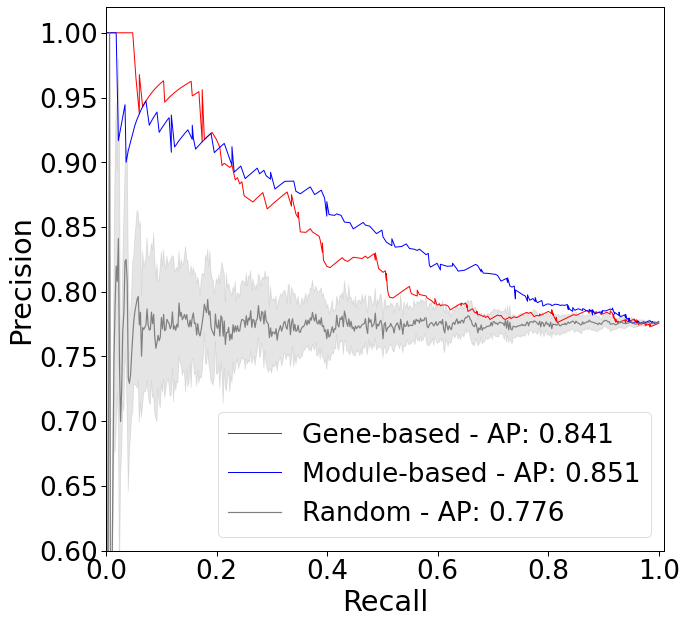

In [22]:
plot_pr_for_methods(methods_names)
# plt.savefig('/tmp/pr.pdf', bbox_inches='tight')